# Обучение сети c несколькими параметрами

Параметры обучения: Vgs, Vds, L, W, Temp

In [3]:
import numpy as np
import pandas as pd
import time

In [4]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0

In [5]:
# !python -m pip install tensorflow

Загружаем свой датасет


In [6]:
df = pd.read_csv('mosfet.csv')

# df = pd.read_csv('training_data.csv')

In [7]:
df.shape

(529056, 6)

In [8]:
df.describe()

,Vds,Vgs,L,W,T,Id
count,529056.000000,529056.00000,529056.000000,529056.000000,529056.000000,529056.000000
mean,2.500000,2.50000,0.000006,0.000005,30.000000,0.001377
std,1.446261,1.58114,0.000003,0.000003,34.156535,0.003317
min,0.000000,0.00000,0.000001,0.000001,-20.000000,-0.000000
25%,1.250000,1.00000,0.000003,0.000003,0.000000,0.000022
50%,2.500000,2.50000,0.000005,0.000005,30.000000,0.000246
75%,3.750000,4.00000,0.000008,0.000008,60.000000,0.001157
max,5.000000,5.00000,0.000010,0.000010,80.000000,0.042091


In [9]:
# df['Vds'].unique() 

In [10]:
df['L'].unique() 

array([1.e-06, 4.e-06, 7.e-06, 1.e-05])

In [11]:
df['W'].unique() 

array([1.e-06, 4.e-06, 7.e-06, 1.e-05])

In [12]:
df['T'].unique() 

array([-20.,   0.,  20.,  40.,  60.,  80.])

## Подготовка данных

Подготовим входные данные и заменим нули

In [13]:
df[df['Id'] != 0.0]['Id'].min()

1.0000889070673754e-14

In [14]:
df[df['Vgs'] != 0.0]['Vgs'].min()

0.5

In [15]:
df[df['Vds'] != 0.0]['Vds'].min()

0.01

In [16]:
REPLACE_ZERO_ID = 1e-15
REPLACE_ZERO_VGS = 1e-3
REPLACE_ZERO_VDS = 1e-3
# REPLACE_ZERO_T = 0.1
SHIFT_T = 30

In [17]:
# Replace zeros
df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)
# df["T"].replace({0:REPLACE_ZERO_T}, inplace=True)

# fix negative numbers
df["T"] += SHIFT_T

# get data

id=df["Id"]
Vgs=df["Vgs"]
Vds=df["Vds"]
L=df["L"]
W=df["W"]
T=df["T"]


y_raw=np.ravel(id)
X_raw=df.iloc[:,0:5]

In [18]:
X_raw

,Vds,Vgs,L,W,T
0,0.001,0.001,0.000001,0.000001,10.0
1,0.010,0.001,0.000001,0.000001,10.0
2,0.020,0.001,0.000001,0.000001,10.0
3,0.030,0.001,0.000001,0.000001,10.0
4,0.040,0.001,0.000001,0.000001,10.0
...,...,...,...,...,...
529051,4.960,5.000,0.000010,0.000010,110.0
529052,4.970,5.000,0.000010,0.000010,110.0
529053,4.980,5.000,0.000010,0.000010,110.0
529054,4.990,5.000,0.000010,0.000010,110.0


In [19]:
#Normalize data before training

X=np.log10(X_raw)
y=-1/np.log10(y_raw)

# X=np.log(X_raw)
#y=np.log10(y_raw)
# y=-1/np.log(y_raw)

In [20]:
X

,Vds,Vgs,L,W,T
0,-3.000000,-3.00000,-6.0,-6.0,1.000000
1,-2.000000,-3.00000,-6.0,-6.0,1.000000
2,-1.698970,-3.00000,-6.0,-6.0,1.000000
3,-1.522879,-3.00000,-6.0,-6.0,1.000000
4,-1.397940,-3.00000,-6.0,-6.0,1.000000
...,...,...,...,...,...
529051,0.695482,0.69897,-5.0,-5.0,2.041393
529052,0.696356,0.69897,-5.0,-5.0,2.041393
529053,0.697229,0.69897,-5.0,-5.0,2.041393
529054,0.698101,0.69897,-5.0,-5.0,2.041393


**Разделение набора данных на обучающий и тестовый наборы**

In [21]:
# !pip install sklearn

In [22]:
# Split train and test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Нормализуем значения $I_d$ так чтобы выходные значения были в пределах 0 и 1

In [23]:
y_train=y_train.reshape(-1,1) #reshape the data before feeding to network
y_test=y_test.reshape(-1,1)

## Построение модели

**Import Tensorflow and Keras**

In [24]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.test.gpu_device_name()

Note: Relu as activation finction may be used for hidden layers but result might not be smooth. For any compact model, it should be continuous so that it is compatible with Newton algorithm which is used in SPICE simulators.

In [25]:
# We'll use Keras to create a Neural network

# 5 - 32 - 16 - 1

model = tf.keras.Sequential()

model.add(keras.layers.Dense(32, activation='tanh', input_shape=(5,)))
model.add(keras.layers.Dense(16, activation='tanh'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [27]:
t1 = time.perf_counter()

history_1 = model.fit(X_train, y_train, 
                      epochs=500, 
                      validation_data=(X_test, y_test),
                      batch_size=128,
                      shuffle=True,
                      # validation_freq=2,
                      )

print('time taken to run:',time.perf_counter()-t1)

Epoch 1/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.4212e-07 - mae: 3.9167e-04 - val_loss: 2.0865e-07 - val_mae: 2.9869e-04
Epoch 2/500
3307/3307 [==============================] - 10s 3ms/step - loss: 2.8478e-07 - mae: 3.7961e-04 - val_loss: 2.3875e-07 - val_mae: 2.7593e-04
Epoch 3/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.0923e-07 - mae: 3.8549e-04 - val_loss: 1.4306e-07 - val_mae: 2.8079e-04
Epoch 4/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.2952e-07 - mae: 3.8962e-04 - val_loss: 1.8291e-07 - val_mae: 2.9611e-04
Epoch 5/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.1593e-07 - mae: 3.8323e-04 - val_loss: 2.7305e-07 - val_mae: 4.1008e-04
Epoch 6/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.1120e-07 - mae: 3.9444e-04 - val_loss: 1.1165e-07 - val_mae: 2.1650e-04
Epoch 7/500
3307/3307 [==============================] - 10s 3ms/step - loss: 3.0557e-07

Сохраним веса в виде файла

In [28]:
model.save("model_32_16.h5") # save weights

Загрузим веса из файла (по необходимости)

In [29]:
model.load_weights("model_32_16.h5") # load weights

### Создадим сеть с другой архитектурой

P.S. Пока не обучалось

In [ ]:
# Сreate another Neural network

# 2 - 16 - 8 - 4 - 1

model_16_8_4 = tf.keras.Sequential()

model_16_8_4.add(keras.layers.Dense(16, activation='tanh', input_shape=(2,)))
model_16_8_4.add(keras.layers.Dense(8, activation='tanh'))
model_16_8_4.add(keras.layers.Dense(4,activation='tanh'))
model_16_8_4.add(keras.layers.Dense(1, activation='sigmoid'))

model_16_8_4.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_16_8_4.summary()

In [ ]:
t1 = time.perf_counter()

history_2 = model_16_8_4.fit(X_train, y_train, 
                      epochs=2500, 
                      validation_data=(X_test, y_test),
                      batch_size=32,
                      shuffle=True,
                      )

print('time taken to run:',time.perf_counter()-t1)

In [ ]:
model_16_8_4.save("model_16_8_4.h5") # save weights

In [ ]:
model_16_8_4.load_weights("model_16_8_4.h5") # load weights

### **Построим графики loss моделей**

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

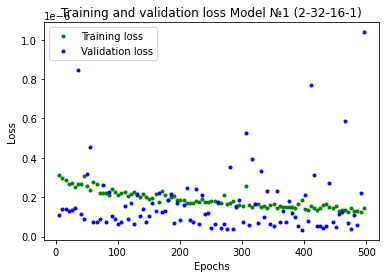

In [33]:
# Exclude the first few epochs so the graph is easier to read
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(loss) + 1)
SKIP = 5
# SKIP = 0
plt.plot(epochs[SKIP::5], loss[SKIP::5], 'g.', label='Training loss')
plt.plot(epochs[SKIP::5], val_loss[SKIP::5], 'b.', label='Validation loss')
plt.title('Training and validation loss Model №1 (2-32-16-1)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Тестирование обученной сети

Применим новые данные, на которых сеть не обучалась. 

При этом не забудем про подготовку входных и выходных параметров. 

In [40]:
def process_data(df):
  # Replace zeros
  df["Id"].replace({0:REPLACE_ZERO_ID}, inplace=True)
  df["Vgs"].replace({0:REPLACE_ZERO_VGS}, inplace=True)
  df["Vds"].replace({0:REPLACE_ZERO_VDS}, inplace=True)

  # fix negative numbers
  df["T"] += SHIFT_T

  # get data

  id=df["Id"]
  Vgs=df["Vgs"]
  Vds=df["Vds"]
  L=df["L"]
  W=df["W"]
  T=df["T"]

  ynew=np.ravel(id)
  xnew=df.iloc[:,0:5]

  #Normalize validation data
  xval=np.log10(xnew)
  #xval=xnew/5
  yval=-1/np.log10(ynew)
  yval=yval.reshape(-1,1)

  return xval, yval, df

In [39]:
df1 = pd.read_csv('mosfet_val_3.csv')

In [41]:
# df1 = df1[df1['Vgs'] == 1]
df1

,Vds,Vgs,L,W,T,Id
0,0.0,4.0,0.000005,0.000005,25.0,-0.000000
1,0.5,4.0,0.000005,0.000005,25.0,0.000329
2,1.0,4.0,0.000005,0.000005,25.0,0.000652
3,1.5,4.0,0.000005,0.000005,25.0,0.000956
4,2.0,4.0,0.000005,0.000005,25.0,0.001230
5,2.5,4.0,0.000005,0.000005,25.0,0.001462
6,3.0,4.0,0.000005,0.000005,25.0,0.001642
7,3.5,4.0,0.000005,0.000005,25.0,0.001758
8,4.0,4.0,0.000005,0.000005,25.0,0.001848
9,4.5,4.0,0.000005,0.000005,25.0,0.001939


In [42]:
xval, yval, df1 = process_data(df1)

**Plot actual vs. predicted result. Make sure that predicted drain current is de-normalized before plotting.**

*De-normalization required because before feeding to network (training phase), we have converted drain current within 0 to 1 range  so that Sigmoid function can operate. So, predicted current value will be within same range. It should be converted back to it's original form (De-normalization)*

In [43]:
def show_plot(xval, yval, df):
  # Predict the new dataset
  y_pred = model.predict(xval)
  # y_pred_16_8_4 = model.predict(xval)
  #plot the result
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)
  # print(vg)
  plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')
  plt.plot(vg, 10**(-1/y_pred), 'b', label='Predicted')
  # plt.plot(vg, 10**(-1/y_pred_16_8_4), 'g', label='Predicted')
  # plt.yscale("log")
  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()

Вспомним что область обучения лежала в пределах 0 до 5 для напржений

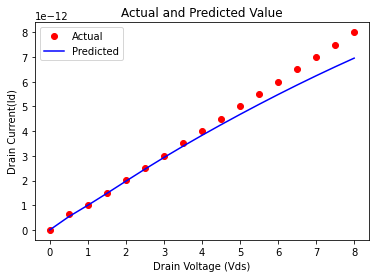

In [55]:
df1 = pd.read_csv('mosfet_val_3.csv')
xval, yval, df1 = process_data(df1)
show_plot(xval, yval, df1)

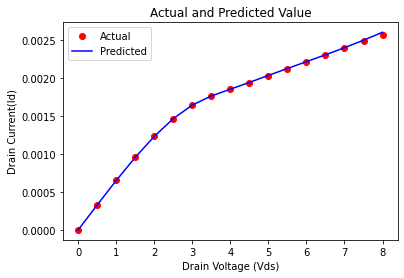

In [56]:
df1 = pd.read_csv('mosfet_val_4.csv')
xval, yval, df1 = process_data(df1)
show_plot(xval, yval, df1)

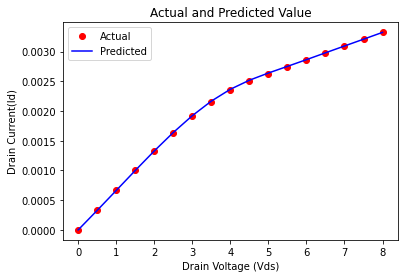

In [57]:
df1 = pd.read_csv('mosfet_val_5.csv')
xval, yval, df1 = process_data(df1)
show_plot(xval, yval, df1)

Посчитаем MSE для валиадционных данных внутри области обчения

In [67]:
df_val = pd.read_csv('mosfet_val_0.csv')

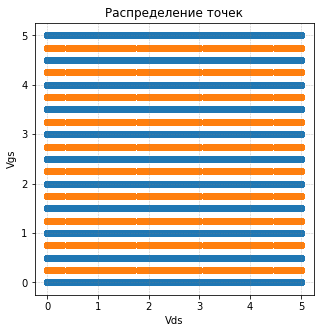

In [68]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['Vds']
y_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

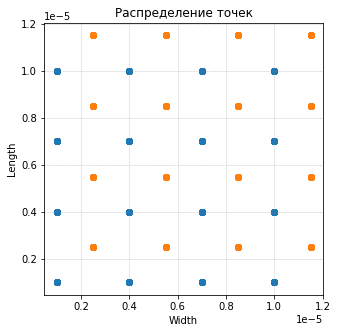

In [76]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['W']
y_val = df_val[df_val['T'] == df_val.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

In [69]:
xval, yval, df_val = process_data(df_val)
y_pred = model.predict(xval)

In [70]:
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
l = keras.losses.MSE(yval, y_pred)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

1.9499769e-08 0.012345694
tf.Tensor(4.0177178e-11, shape=(), dtype=float32)


Посчитаем MSE на данных, которые находятся вне области обучения



In [73]:
df_val_out = pd.read_csv('mosfet_val_1.csv')

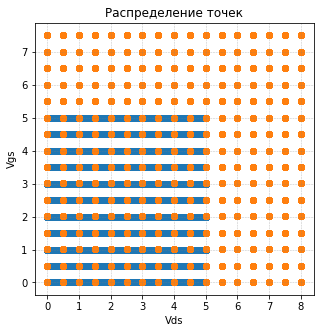

In [75]:
x = df[df['T'] == df.iloc[0]['T']]['Vds']
y = df[df['T'] == df.iloc[0]['T']]['Vgs']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vds']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['Vgs']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Vds', ylabel='Vgs', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

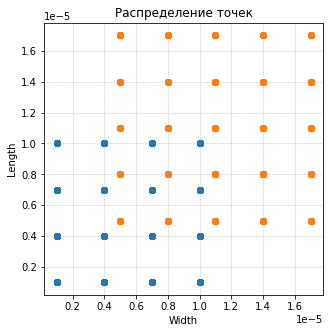

In [77]:
x = df[df['T'] == df.iloc[0]['T']]['W']
y = df[df['T'] == df.iloc[0]['T']]['L']

x_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['W']
y_val = df_val_out[df_val_out['T'] == df_val_out.iloc[0]['T']]['L']

fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlabel='Width', ylabel='Length', title='Распределение точек')
ax.grid(color='gray', alpha=0.5, linestyle='dashed', linewidth=0.5)

plt.scatter(x, y)
plt.scatter(x_val, y_val)
plt.show()

In [78]:
xval, yval, df_val = process_data(df_val_out)
y_pred = model.predict(xval)
loss = keras.losses.MSE(10**(-1/yval), 10**(-1/y_pred))
l = keras.losses.MSE(yval, y_pred)
print(np.max(loss), np.max(l))
loss = tf.reduce_mean(loss) # Рассчитать среднеквадратичную ошибку партии
print(loss)

0.004125962 0.5961268
tf.Tensor(0.00031278984, shape=(), dtype=float32)


In [98]:
df1 = df_val_out.iloc[-64:-32]

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


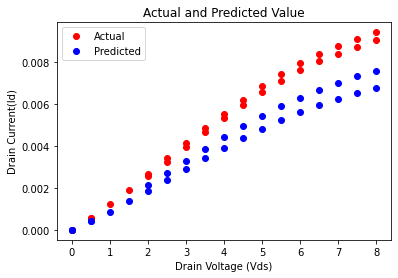

In [99]:
xval, yval, df_val = process_data(df1)
show_plot(xval, yval, df1)

In [94]:
def show_plot(xval, yval, df):
  # Predict the new dataset
  y_pred = model.predict(xval)
  # y_pred_16_8_4 = model.predict(xval)
  #plot the result
  vg1=df["Vds"] #change this index to vgs if you are going to plot Id-Vg
  vg=np.ravel(vg1)
  vg=vg.reshape(-1,1)
  # print(vg)
  plt.plot(vg, 10**(-1/yval), 'ro', label='Actual')
  plt.plot(vg, 10**(-1/y_pred), 'bo', label='Predicted')
  # plt.plot(vg, 10**(-1/y_pred_16_8_4), 'g', label='Predicted')
  # plt.yscale("log")
  plt.title('Actual and Predicted Value')
  plt.xlabel('Drain Voltage (Vds)')
  plt.ylabel('Drain Current(Id)')
  plt.legend()

*The code presented here is a part of our model development framework. Hope, it will encourage others to develop MOSFET models based upon Neural network.*